# Quadcopter
## Summary
This notebook outlines a the design of a motion controller for a quadcopter.

## Goals
The ultimate goal is to apply the designed control system to a simulated environment - for this I have chosen Python and specifially [pybullet](https://pybullet.org/) as the 3D physics simulator and [pyglet](http://www.pyglet.org) as the game engine to render the results.

### Control System Requirements
The design criteria for the quadrotor is to reach a step input in 3D space of (1, 1, 1):
* Settling time for x, y, z and yaw (ψ) of less than 5 seconds
* Rise time for x, y, z and yaw (ψ) of less than 2 seconds
* Overshoot of x, y, z and yaw (ψ) less than 5% 

## System Description
We will use the following diagram to derive the equations of motion:

TODO - add diagram

* coordinate system and inertial frame is defined with the positive z axis in the opposite direction of gravity
* x, y, and z are the coordinates of the quadcopter centre of mass (CoM) in the inertial frame
* φ, θ, and ψ are the roll, pitch and yaw about the axes x, y and z respectively, with respect to the inertial frame - angles are 0 radians when the quadcopter is hovering, angles are measured CCW when 'looking down' the axis of rotation in the inertial frame
* rotors directly across from eachother rotate in the same direction (this allows the quadcopter to change its yaw angle while keeping its position constant)
* $F_1, F_2, F_3, F_4$ are the forces from the rotors, we assume they can only thrust in the positive z direction, with respect to the quadcopter frame
* $M_1, M_2, M_3, M_4$ are the moments of inertia for the rotors, about the z axis 
* $u_1$ and $u_2$ are the motion control system inputs, where $u_1$ controls the throttle, and $u_2$ controls the rotation
* $I$ is the quadcopter moment of inertia (with x, y, and z components)
* $m$ is the mass of the quadcopter, in kg
* $l$ is the distance from the centre of mass to the rotors
* $g$ is gravity
* $R$ is the rotation matrix from the quadcopter frame to the static base frame using the [ZXY Euler angles (Wikipedia)](https://en.wikipedia.org/wiki/Euler_angles#Rotation_matrix) convention
* $\dot{x}, \dot{y}, \dot{z}$ are translational velocities
* $\ddot{x}, \ddot{y}, \ddot{z}$ are translational accelerations
* $\dot{\phi}, \dot{\theta}, \dot{\psi}$ are rotational velocities
* $\ddot{\phi}, \ddot{\theta}, \ddot{\psi}$ are rotational accelerations

## Equations of Motion
We will use the [Newton-Euler equations (Wikipedia)](https://en.wikipedia.org/wiki/Newton%E2%80%93Euler_equations) to define the equations of motion.

Using the [ZXY Euler angles (Wikipedia)](https://en.wikipedia.org/wiki/Euler_angles#Rotation_matrix) convention, we will define the rotation matrix from the quadcopter body frame into the inertial frame as $R$

In [1]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import math

sp.init_printing()

In [2]:
# create our symbols and functions
t, g = sp.symbols('t g')

x = sp.Function('x')(t)
y = sp.Function('y')(t)
z = sp.Function('z')(t)
φ = sp.Function('φ')(t)
θ = sp.Function('θ')(t)
ψ = sp.Function('ψ')(t)

In [3]:
# define the rotation matrices about the axes x, y, and z
Rx = sp.Matrix([[1, 0, 0], [0, sp.cos(φ), -sp.sin(φ)], [0, sp.sin(φ), sp.cos(φ)]])
Ry = sp.Matrix([[sp.cos(θ), 0, sp.sin(θ)], [0, 1, 0], [-sp.sin(θ), 0, sp.cos(θ)]])
Rz = sp.Matrix([[sp.cos(ψ), -sp.sin(ψ), 0], [sp.sin(ψ), sp.cos(ψ), 0], [0, 0, 1]])

# create the euler angle Z-X-Y rotation matrix and print it out
R = Rz*Rx*Ry
R

⎡-sin(θ(t))⋅sin(φ(t))⋅sin(ψ(t)) + cos(θ(t))⋅cos(ψ(t))  -sin(ψ(t))⋅cos(φ(t))  s
⎢                                                                             
⎢sin(θ(t))⋅sin(φ(t))⋅cos(ψ(t)) + sin(ψ(t))⋅cos(θ(t))   cos(φ(t))⋅cos(ψ(t))   s
⎢                                                                             
⎣                -sin(θ(t))⋅cos(φ(t))                       sin(φ(t))         

in(θ(t))⋅cos(ψ(t)) + sin(φ(t))⋅sin(ψ(t))⋅cos(θ(t))⎤
                                                  ⎥
in(θ(t))⋅sin(ψ(t)) - sin(φ(t))⋅cos(θ(t))⋅cos(ψ(t))⎥
                                                  ⎥
               cos(θ(t))⋅cos(φ(t))                ⎦

### Position
Total force $F$ acting on the centre of mass, with respect to the inertial frame.

$ma = F$ where a is acceleration

$m\begin{bmatrix} \ddot{x} \\
\ddot{y} \\
\ddot{z} \end{bmatrix} = \begin{bmatrix} 0 \\
0 \\
-mg \end{bmatrix} + R\begin{bmatrix} 0 \\
0 \\
F_1+F_2+F_3+F_4\end{bmatrix}$

### Rotation
Total torque $\tau$ acting on the centre of mass with respect to the body frame.

$I\alpha = \tau - \omega\times I\omega$ where $\alpha$ is angular acceleration, $\omega$ is angular velocity, and $I$ is the [inertia tensor (Wikipedia)](https://en.wikipedia.org/wiki/Moment_of_inertia#Inertia_tensor) of the quadcopter:

$I = \begin{bmatrix} I_{xx} & I_{xy} & I_{xz} \\ 
I_{yx} & I_{yy} & I_{yz} \\ 
I_{zx} & I_{zy} & I_{zz} \end{bmatrix}$

The angular velocity with respect to the body fixed frame is required to fill out this equation.

We can define a time based function that transforms a fixed point $p_b$ in the body frame to the inertial frame as $p_i(t)$:

$p_i(t) = R(t)p_b$

Taking the time derivative gives us the velocity in the inertial frame:

$\dot{p_i(t)} = \dot{R(t)}p_b$

To get the velocity in a body fixed frame, we can multiply by the transpose of the rotation matrix (since the original matrix is converting from body to fixed):

$R^T\dot{p_i(t)} = R^T\dot{R(t)}p_b$

The term $R^T\dot{R(t)}$ can then be used to convert angular velocities in an inertial frame into a body fixed frame.

#### Alternative Calculation
**NOTE:** help needed here...to use this calculation, I also had to negate the result, but not sure why - something to do with skew symmetry?

The angular velocity with respect to the body fixed frame is required to fill out this equation. We can use the rotation matrix from the body frame to inertial frame to calculate the [angular velocity vector (Wikipedia)]((https://en.wikipedia.org/wiki/Rotation_formalisms_in_three_dimensions#Rotation_matrix_%E2%86%94_angular_velocities)) in the body frame:

$\begin{bmatrix} 0 & -\omega_z & \omega_y \\
\omega_z & 0 & -\omega_x \\
-\omega_y & \omega_x & 0 \end{bmatrix} = \dot{A}A^T$

We must first invert/transpose the rotation matrix so we can get the transformation from inertial frame into body frame.

In python we could do the following:
```python
# hack alert! had to negate the value to get it to work...
A = R.transpose()
ω = -sp.simplify(A.diff(t)*A.transpose())
```

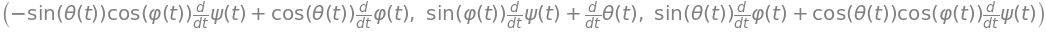

In [4]:
# calculate the angular velocity in the body fixed frame
ω = sp.simplify(R.transpose()*R.diff(t))

ω_x = ω[2, 1]
ω_y = ω[0, 2]
ω_z = ω[1, 0]

# print out the equations for the components of omega
ω_x, ω_y, ω_z

Rearranging for the angular velocities above:

$\omega = \begin{bmatrix} \omega_x \\
\omega_y \\
\omega_z \end{bmatrix} = \begin{bmatrix} \cos\theta & 0 & -\cos\phi\sin\theta \\
0 & 1 & \sin\phi \\
\sin\theta & 0 & \cos\phi\cos\theta \end{bmatrix} \begin{bmatrix} \dot{\phi} \\
\dot{\theta} \\
\dot{\psi} \end{bmatrix}$

and putting it all together:

$I\begin{bmatrix} \dot{\omega_x} \\
\dot{\omega_y} \\
\dot{\omega_z} \end{bmatrix} = \begin{bmatrix}  l(F_2 - F_4) \\
l(F_3 - F_1) \\
M_1-M_2+M_3-M_4 \end{bmatrix} - \begin{bmatrix} \omega_x \\
\omega_y \\
\omega_z \end{bmatrix} \times I \begin{bmatrix} \omega_x \\
\omega_y \\
\omega_z \end{bmatrix}$

## Approximations for Hover
We will linearize our equations at a stable hover, where we make the following approximations:  
* position will be constant and equal to its initial value
* time derivatives of position (e.g. velocity and acceleration) will then be 0
* roll and pitch will be constant and approximately 0
* yaw will be constant and equal to its initial value
* time derivatives of rotation (e.g. angular velocity and acceleration) will also be 0
* the sine of a small value can then be assigned to the small value
* the cosine of a small value can then be assigned to 1
* the non-principal moments of inertia are 0

Or:  

$\cos\phi \approx 1 \\ 
\sin\phi \approx \phi \\
\cos\theta \approx 1 \\ 
\sin\theta \approx \theta$

The rotation matrix from body frame into inertial frame becomes:  

$R = \begin{bmatrix} r11 & r12 & r13 \\ 
r21 & r22 & r23 \\ 
r31 & r32 & r33 \end{bmatrix} = \begin{bmatrix} \cos\psi - \sin\psi\phi\theta & -\sin\psi & \cos\psi\theta + \sin\psi\phi \\ 
\sin\psi + \cos\psi\phi\theta & \cos\psi & \sin\psi\theta - \cos\psi\phi \\ 
-\theta & \phi & 1 \end{bmatrix}$

### Position

We will define thrust input $u_1 = F_1+F_2+F_3+F_4$ and our force equation becomes:

$m\begin{bmatrix} \ddot{x} \\
\ddot{y} \\
\ddot{z} \end{bmatrix} = \begin{bmatrix} 0 \\
0 \\
-mg \end{bmatrix} + \begin{bmatrix} \cos\psi\theta + \sin\psi\phi \\
\sin\psi\theta - \cos\psi\phi \\
1\end{bmatrix}u_1$

The second derivative of time (acceleration) is proportional to $u_1$.

### Rotation
Assuming the non-principal components of inertia are 0 gives us a revised inertia tensor:

$I = \begin{bmatrix} I_{xx} & 0 & 0 \\ 
0 & I_{yy} & 0 \\ 
0 & 0 & I_{zz} \end{bmatrix}$

Linearizing our rotational equations gives us:

$\omega = \begin{bmatrix} \omega_x \\
\omega_y \\
\omega_z \end{bmatrix} = \begin{bmatrix} 1 & 0 & -\theta \\
0 & 1 & \phi \\
\theta & 0 & 1 \end{bmatrix} \begin{bmatrix} \dot{\phi} \\
\dot{\theta} \\
\dot{\psi} \end{bmatrix}$

and also considering that the products of two small numbers is a really small number (the angular velocities are all small), gives us:

$\omega = \begin{bmatrix} \omega_x \\
\omega_y \\
\omega_z \end{bmatrix} = \begin{bmatrix} \dot{\phi} \\
\dot{\theta} \\
\dot{\psi} \end{bmatrix}$

Let $u_2$ be:

$u_2 = \begin{bmatrix} u_{2x} \\
u_{2y} \\
u_{2z} \\
\end{bmatrix} = \begin{bmatrix} l(F_2 - F_4) \\
l(F_3 - F_1) \\
M_1-M_2+M_3-M_4 \end{bmatrix}$

Filling in our torque equation:

$\begin{bmatrix} I_{xx} & 0 & 0 \\ 
0 & I_{yy} & 0 \\ 
0 & 0 & I_{zz} \end{bmatrix} \begin{bmatrix} \dot{\omega_x} \\
\dot{\omega_y} \\
\dot{\omega_z} \end{bmatrix} = \begin{bmatrix} u_{2x} \\
u_{2y} \\
u_{2z} \end{bmatrix} - \begin{bmatrix} 0 & -\omega_z & \omega_y \\
\omega_z & 0 & -\omega_x \\
-\omega_y & \omega_x & 0 \end{bmatrix} \begin{bmatrix} I_{xx} & 0 & 0 \\ 
0 & I_{yy} & 0 \\ 
0 & 0 & I_{zz} \end{bmatrix} \begin{bmatrix} \omega_x \\
\omega_y \\
\omega_z \end{bmatrix}$

$\begin{bmatrix} I_{xx}\dot{\omega_x} \\ 
I_{yy}\dot{\omega_y} \\ 
I_{zz}\dot{\omega_z} \end{bmatrix} = \begin{bmatrix} u_{2x} + I_{yy}\omega_y\omega_z - I_{zz}\omega_z\omega_y \\
u_{2y} - I_{xx}\omega_x\omega_z + I_{zz}\omega_z\omega_x \\
u_{2z} + I_{xx}\omega_x\omega_y - I_{zz}\omega_z\omega_x \end{bmatrix}$

and also approximating that the $\omega_i$ terms multiplied together are approximately zero, we can rearrange and define the following equations:

$I_{xx}\ddot{\phi} = u_{2x} \\
I_{yy}\ddot{\theta} = u_{2y} \\
I_{zz}\ddot{\psi} = u_{2z}$

and finally get equations for the angular accelerations:

$\ddot{\phi} = \dfrac{u_{2x}}{I_{xx}} \\
\ddot{\theta} = \dfrac{u_{2y}}{I_{yy}} \\
\ddot{\psi} = \dfrac{u_{2z}}{I_{zz}}$

by taking one of the linearized equations for position, e.g. $m\ddot{x}$ and then differentiating against time twice, we can substitute in the above equations and observe that the input $u_2$ is proportional to the fourth derivative of time (snap). This means we will desire a minimum snap trajectory to smoothly control a quadcopter (citation needed).

## State Space Representation
This system has 12 states - position, rotation and their associated velocities.

*NOTE: linearized equations for hover*

$x(t) = \begin{bmatrix} x_0 \\
x_1 \\
x_2 \\
x_3 \\
x_4 \\
x_5 \\
x_6 \\
x_7 \\
x_8 \\
x_9 \\
x_{10} \\
x_{11} \end{bmatrix} = \begin{bmatrix} x \\
y \\
z \\
\phi \\
\theta \\
\psi \\
\dot{x} \\
\dot{y} \\
\dot{z} \\
\dot{\phi} \\
\dot{\theta} \\
\dot{\psi} \end{bmatrix}, \dot{x(t)} = \begin{bmatrix} \dot{x_0} \\
\dot{x_1} \\
\dot{x_1} \\
\dot{x_2} \\
\dot{x_3} \\
\dot{x_4} \\
\dot{x_5} \\
\dot{x_6} \\
\dot{x_7} \\
\dot{x_8} \\
\dot{x_9} \\
\dot{x_{10}} \\
\dot{x_{11}} \end{bmatrix} = \begin{bmatrix} x_6 \\
x_7 \\
x_8 \\
x_9 \\
x_{10} \\
x_{11} \\
\ddot{x} \\
\ddot{y} \\
\ddot{z} \\
\ddot{\phi} \\
\ddot{\theta} \\
\ddot{\psi} \end{bmatrix} = \begin{bmatrix} x_6 \\
x_7 \\
x_8 \\
x_9 \\
x_{10} \\
x_{11} \\
\dfrac{(\cos\psi\theta + \sin\psi\phi)u_1}{m} \\
\dfrac{(\sin\psi\theta - \cos\psi\phi)u_1}{m} \\
\dfrac{u_1}{m} - g \\
\dfrac{u_{2x}}{I_{xx}} \\
\dfrac{u_{2y}}{I_{yy}} \\
\dfrac{u_{2z}}{I_{zz}} \end{bmatrix}$

where:

$u(t) = \begin{bmatrix} u_1 \\
u_{2x} \\
u_{2y} \\
u_{2z} \end{bmatrix} = \begin{bmatrix} F_1+F_2+F_3+F_4 \\
l(F_2 - F_4) \\
l(F_3 - F_1) \\
M_1-M_2+M_3-M_4 \end{bmatrix}$

## Control

The following diagram represents the control system:

![quadcopter control diagram](../res/img/quad-control-diagram.png "Quadcopter Control Diagram")

1. the trajectory generator provides the desired position and yaw to the position controller
1. the position controller reads the current quadcopter position state, determines commanded pitch, roll, and yaw values and sends that to the attitude controller, and simultaneously determines the thrust input ($u_1$) and sends that to the motion controller
1. the attitude controller reads the current quadcopter rotation state, and determines the rotation input ($u_2$) and sends that to the motion controller
1. the motion controller solves for the 4 rotor forces based on the given inputs ($u_1 and u_2$) and updates the quadcopter with the current required forces

UML code provided here in case of edits - image generated on [PlantUML](https://plantuml.com/):  
```
@startuml
[Trajectory\nGenerator] -right-> [Position\nController] : desired\nx,y,z,𝜓
[Position\nController] -right-> [Motion\nController] : u1
[Position\nController] -down-> [Attitude\nController] : commanded\n𝜙,𝜃,𝜓
[Attitude\nController] -> [Motion\nController] : u2
[Motion\nController] -right-> [Quadcopter]
[Quadcopter] -down-> [Attitude\nController] : 𝜙,𝜃,𝜓,\nd/dt(𝜙,𝜃,𝜓)
[Quadcopter] -> [Position\nController] : x,y,z,\nd/dt(x,y,z)
@enduml
```

### PID Controllers
We can use [proportional–integral–derivative (PID) controllers (Wikipedia)](https://en.wikipedia.org/wiki/PID_controller) to reach our desired states. In general, to calculate an time based input $u(t)$ based on the time based error $e(t)$ the equation is as follows:

$u(t) = K_pe(t) + K_i\int_0^t \! e(t) + K_d\dot{(e(t)}$

For simplicity, we will ignore the integral term and implement a PD controller to focus on the current error in position and velocity, and ignore the accumulated error (we would want to include this for a real world application, but for an ideal simulation we can ignore it).

#### Position
For position, we will have the following control equations (c = commanded, d = desired):

$\begin{bmatrix} \ddot{x_c} \\
\ddot{y_c} \\
\ddot{z_c}
\end{bmatrix} = \begin{bmatrix} \ddot{x_d} + K_{p,x}(x_d - x) + K_{d,x}(\dot{x_d} - \dot{x}) \\
\ddot{y_d} + K_{p,y}(y_d - y) + K_{d,y}(\dot{y_d} - \dot{y}) \\
\ddot{z_d} + K_{p,z}(z_d - z) + K_{d,z}(\dot{z_d} - \dot{z})
\end{bmatrix}$

We can then calculate $u_1$, which is simply the combined acceleration of commanded acceleration and gravity, multiplied by the quadcopter mass:

$u_1 = m(g+\ddot{z_c}) = m(g + \ddot{z_d} + K_{p,\ddot{z}}(z_d - z) + K_{d,\ddot{z}}(\dot{z_d} - \dot{z}))$

#### Rotation
For rotation, once we have the commanded position accelerations, we can calculate the commanded rotations using trigonometry (c = commanded, d = desired):

$\begin{bmatrix} \phi_c \\
\theta_c \\
\psi_c
\end{bmatrix} = \begin{bmatrix} \dfrac{\ddot{x_c}\sin{\psi_d} - \ddot{y_c}\cos{\psi_d}}{g} \\
\dfrac{\ddot{x_c}\cos{\psi_d} + \ddot{y_c}\sin{\psi_d}}{g} \\
\psi_d
\end{bmatrix}$

*NOTE: We can use the above to calculate the commanded angular velocities and accelerations by taking 2 time derivatives. This will result in a requirement to calculate the commanded jerk and snap for x and y, which we can get from taking 2 time derivatives of our x and y accelerations above. This is why $u_2$ is dependent on the fourth time derivative of position. Commanded jerk and snap for x and y also assumes we can calculate the current jerk and acceleration of the quadcopter.*

and then calculate $u_2$:

$u_2 = \begin{bmatrix} u_{2x} \\
u_{2y} \\
u_{2z}
\end{bmatrix} = \begin{bmatrix} \ddot\phi_c + K_{p,\phi}(\phi_c - \phi) + K_{d,\phi}(\dot{\phi_c} - \dot{\phi}) \\
\ddot\theta_c + K_{p,\theta}(\theta_c - \theta) + K_{d,\theta}(\dot{\theta_c} - \dot{\theta}) \\
\ddot\psi_c + K_{p,\psi}(\psi_c - \psi) + K_{d,\psi}(\dot{\psi_c} - \dot{\psi})
\end{bmatrix}$

#### Motion Control
Now that we have our input $u$ we can then solve for the required rotor forces, and send those to the quadcopter.

*NOTE: in reality we would want to calculate the voltage required to reach a desired rotor speed in order to create the force, but for the purposes of our ideal simulation, we will just use the forces and moments.*

We now have a system of 4 equations and 4 unknowns and can use linear algebra to solve the system:

$\begin{bmatrix} u_1 \\
u_{2x} \\
u_{2y} \\
u_{2z} \end{bmatrix} = \begin{bmatrix} F_1+F_2+F_3+F_4 \\
l(F_2 - F_4) \\
l(F_3 - F_1) \\
M_1-M_2+M_3-M_4 \end{bmatrix}$

We will also need to solve for the moments, $M_i$ but these can be linearly related to the force produced. For a propellor, the force and moment can be represented as a product of some constant and the square of the propellor speed (citation needed):

$F = k_f\omega^2 \\
M = k_m\omega^2$

which means we can represent the moments as:

$M_i = \dfrac{k_m}{k_f}F_i$

and substitute appropriately:

$\begin{bmatrix} u_1 \\
u_{2x} \\
u_{2y} \\
u_{2z} \end{bmatrix} = \begin{bmatrix} F_1+F_2+F_3+F_4 \\
l(F_2 - F_4) \\
l(F_3 - F_1) \\
\dfrac{k_m}{k_f}(F_1-F_2+F_3-F_4) \end{bmatrix}$

we can now represent this system as $Af = u$ where the $f$ vector is the unknown forces, and the $A$ matrix is:

$A = \begin{bmatrix} 1 & 1 & 1 & 1 \\
0 & l & 0 & -l \\
-l & 0 & l & 0 \\
\dfrac{k_m}{k_f} & -\dfrac{k_m}{k_f} & \dfrac{k_m}{k_f} & -\dfrac{k_m}{k_f}
\end{bmatrix}$

We can then solve for $f$:

$f = A^{-1}u$

Since A is all constants, we can calculate the inverse of $A$ once and re-use for each iteration of our control loop.

## Simulation
We now have enough data to simulate the system.

### Constants
I will use a master thesis called [*Modelling, Identification and Control
of a Quadrotor Helicopter*](http://lup.lub.lu.se/luur/download?func=downloadFile&recordOId=8847641&fileOId=8859343) by Tommaso Bresciani as a reference to fill in the constants.

### Constant Control
To ensure our model is doing what we expect, we will first simulate conditions where constant inputs are applied.

In [5]:
# define our constants
constants = dict(
    l = 235e-3,    # 23.5 cm from CoM to rotor
    m = 250e-3,    # 250 g
    Ixx = 8.1e-3,  # Nms^2
    Iyy = 8.1e-3,  # Nms^2
    Izz = 14.2e-3, # Nms^2
    g = 9.81,      # gravity, m/s^2,
    kmkf = 50e-6   # km/kf - the ratio of the moment constant over the force constant
)

In [6]:
# define our ivp function using our state space representation
def quadcopter(t, state, forces, constants):
    u1 = sum(forces)
    u2x = constants['l'] * (forces[1] - forces[3])
    u2y = constants['l'] * (forces[2] - forces[0])
    u2z = constants['kmkf'] * (forces[0] - forces[1] + forces[2] - forces[3])
    phi = state[3]
    theta = state[4]
    psi = state[5]
    u1_m = u1 / constants['m']
    x_accel = (math.cos(psi)*theta + math.sin(psi)*phi) * u1_m
    y_accel = (math.sin(psi)*theta - math.cos(psi)*phi) * u1_m
    z_accel = u1_m - constants['g']
    phi_accel = u2x / constants['Ixx']
    theta_accel = u2y / constants['Iyy']
    psi_accel = u2z / constants['Izz']
    updated = np.zeros(12)
    updated[0:6] = state[6:]
    updated[6:] = [x_accel, y_accel, z_accel, phi_accel, theta_accel, psi_accel]
    return updated

In [7]:
# define a plotting function to show all the states
def plot_all(title, t, z):
    plt.figure(figsize=(20, 24))

    plt.subplot(4, 3, 1)
    plt.plot(t, z.T[:,0], 'r')
    plt.xlabel('time (s)')
    plt.ylabel('X position (m)')
    plt.title(title)
    plt.grid(True)

    plt.subplot(4, 3, 2)
    plt.plot(t, z.T[:,1], 'b')
    plt.xlabel('time (s)')
    plt.ylabel('Y position (m)')
    plt.grid(True)

    plt.subplot(4, 3, 3)
    plt.plot(t, z.T[:,2], 'g')
    plt.xlabel('time (s)')
    plt.ylabel('Z position (m)')
    plt.grid(True)

    plt.subplot(4, 3, 4)
    plt.plot(t, z.T[:,3], 'y')
    plt.xlabel('time (s)')
    plt.ylabel('Pitch (radians)')
    plt.grid(True)

    plt.subplot(4, 3, 5)
    plt.plot(t, z.T[:,4], 'm')
    plt.xlabel('time (s)')
    plt.ylabel('Roll (radians)')
    plt.grid(True)

    plt.subplot(4, 3, 6)
    plt.plot(t, z.T[:,5], 'c')
    plt.xlabel('time (s)')
    plt.ylabel('Yaw (radians)')
    plt.grid(True)
    
    plt.subplot(4, 3, 7)
    plt.plot(t, z.T[:,6], 'r')
    plt.xlabel('time (s)')
    plt.ylabel('X velocity (m/s)')
    plt.grid(True)

    plt.subplot(4, 3, 8)
    plt.plot(t, z.T[:,7], 'b')
    plt.xlabel('time (s)')
    plt.ylabel('Y velocity (m/s)')
    plt.grid(True)

    plt.subplot(4, 3, 9)
    plt.plot(t, z.T[:,8], 'g')
    plt.xlabel('time (s)')
    plt.ylabel('Z velocity (m/s)')
    plt.grid(True)

    plt.subplot(4, 3, 10)
    plt.plot(t, z.T[:,9], 'y')
    plt.xlabel('time (s)')
    plt.ylabel('Pitch velocity (radians/s)')
    plt.grid(True)

    plt.subplot(4, 3, 11)
    plt.plot(t, z.T[:,10], 'm')
    plt.xlabel('time (s)')
    plt.ylabel('Roll velocity (radians/s)')
    plt.grid(True)

    plt.subplot(4, 3, 12)
    plt.plot(t, z.T[:,11], 'c')
    plt.xlabel('time (s)')
    plt.ylabel('Yaw velocity (radians/s)')
    plt.grid(True)

    plt.xlabel('time (s)')
    plt.show()

In [8]:
from scipy.integrate import solve_ivp

# let the quadcopter fall
forces = [0.0] * 4

# initial values for state vector
y0 = [0.0] * 12

args = (forces, constants)
sol = solve_ivp(quadcopter, [0, 10], y0, args=args, dense_output=True)

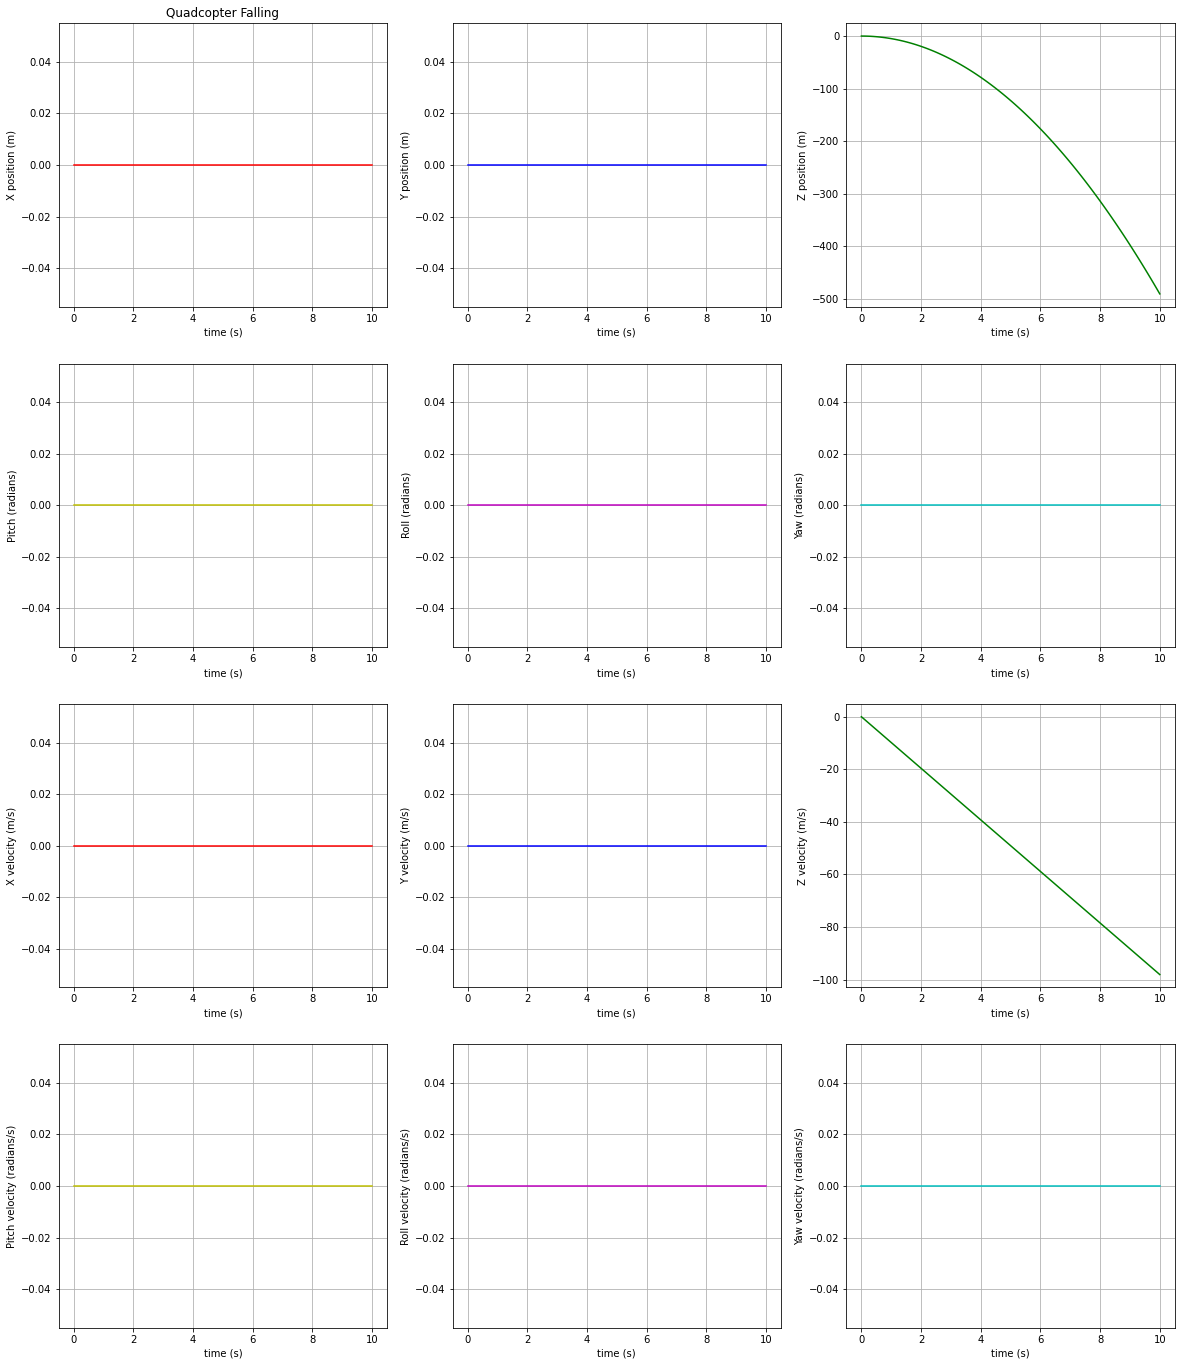

In [9]:
t = np.linspace(0, 10, 100)
z = sol.sol(t)

# we expect the quadcopter to fall from the sky, z decreasing exponentially, and zdot (velocity) increasing linearly, all other states should be 0
plot_all('Quadcopter Falling', t, z)

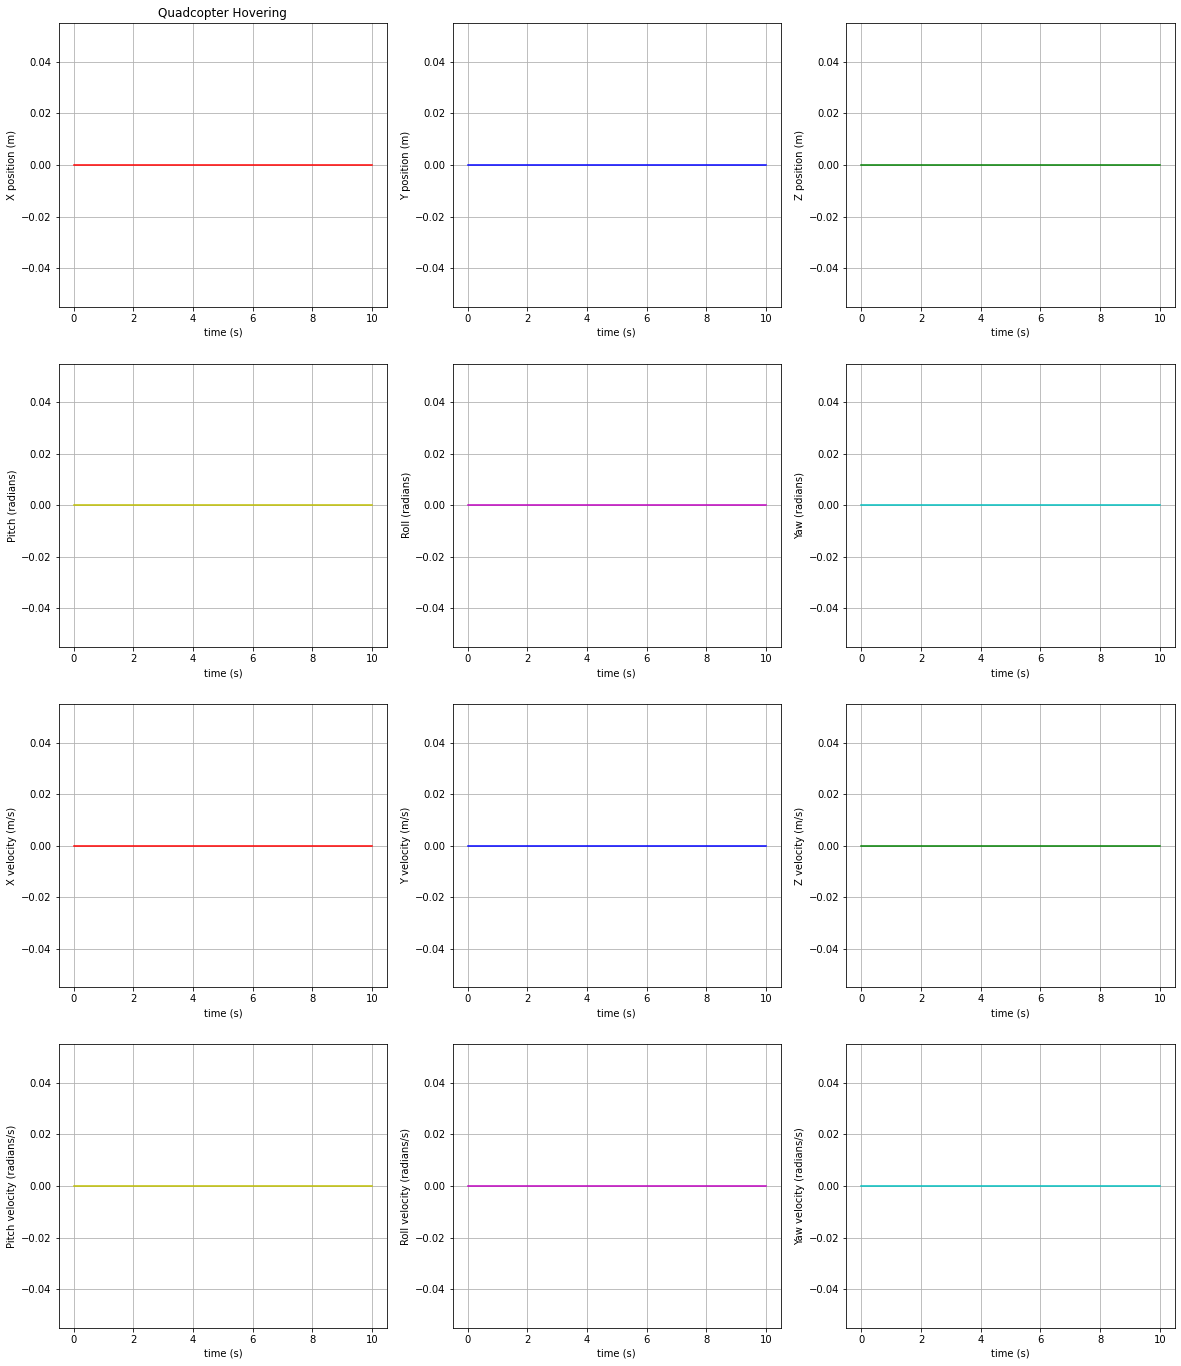

In [10]:
# determine the force required to hover
force = constants['m'] * constants['g'] / 4
forces = [force] * 4

args = (forces, constants)
sol = solve_ivp(quadcopter, [0, 10], y0, args=args, dense_output=True)

t = np.linspace(0, 10, 100)
z = sol.sol(t)

# we expect the quadcopter to hover so all states should be 0
plot_all('Quadcopter Hovering', t, z)

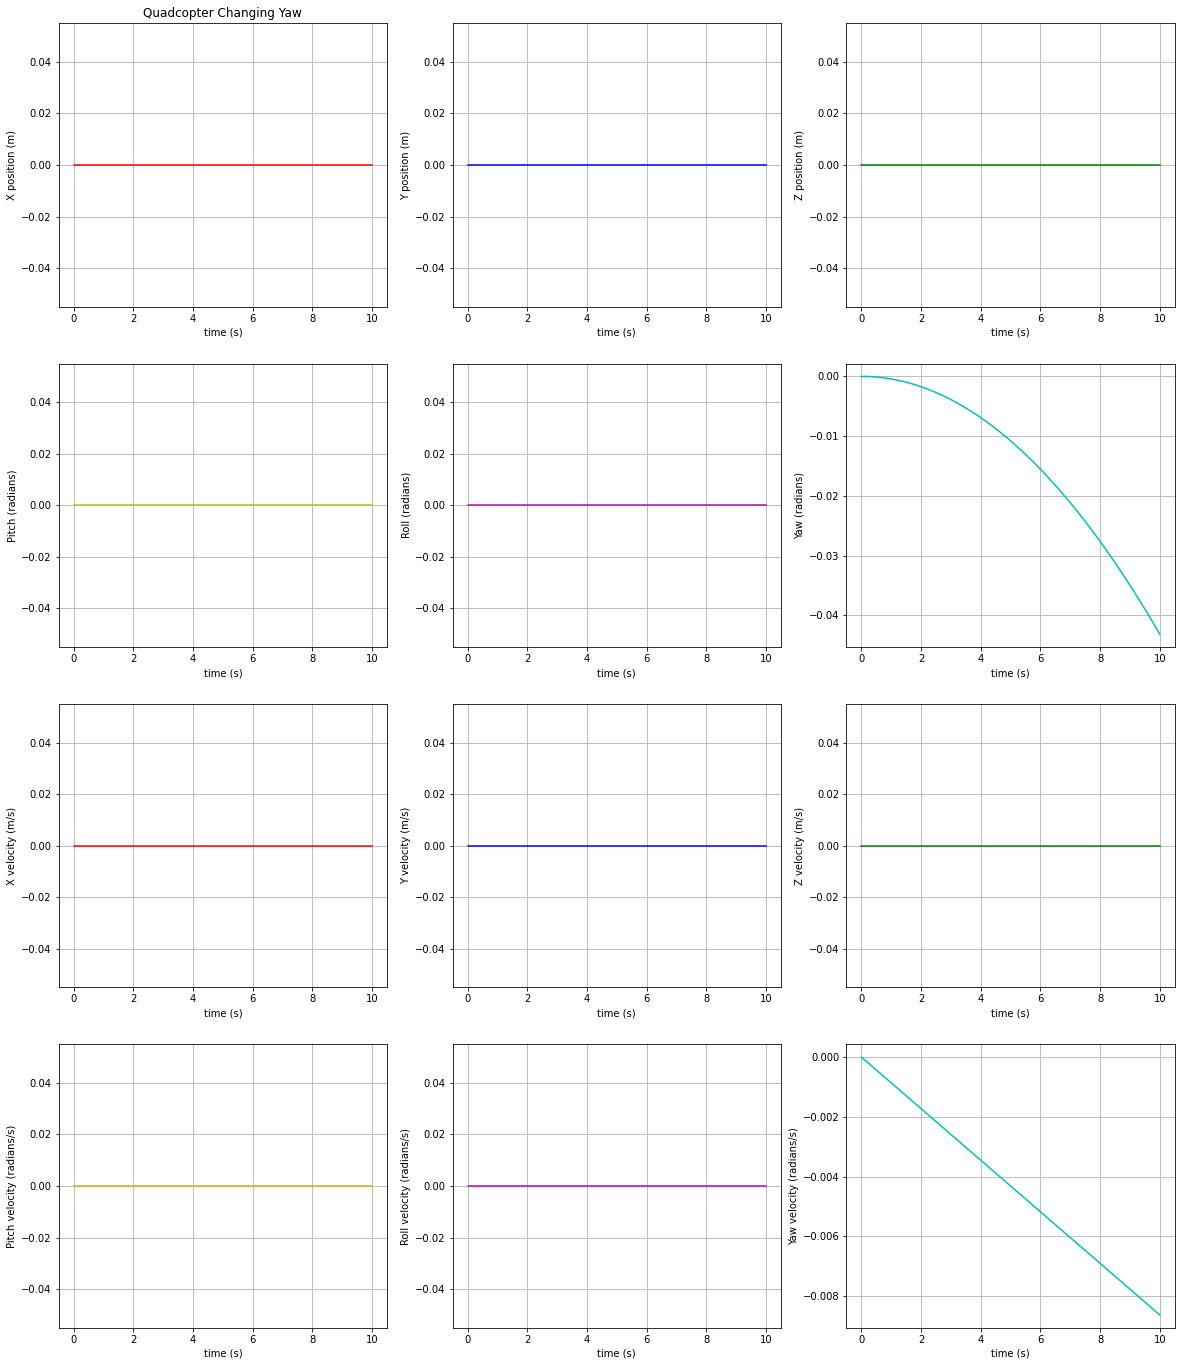

In [11]:
# apply forces such that the quadcopter will change its yaw
force = constants['m'] * constants['g'] / 4
delta_f = force * 0.1
forces = [force] * 4

forces[0] -= delta_f
forces[2] -= delta_f
forces[1] += delta_f
forces[3] += delta_f

args = (forces, constants)
sol = solve_ivp(quadcopter, [0, 10], y0, args=args, dense_output=True)

t = np.linspace(0, 10, 100)
z = sol.sol(t)

# we expect the quadcopter to hover but the yaw should be changing
plot_all('Quadcopter Changing Yaw', t, z)

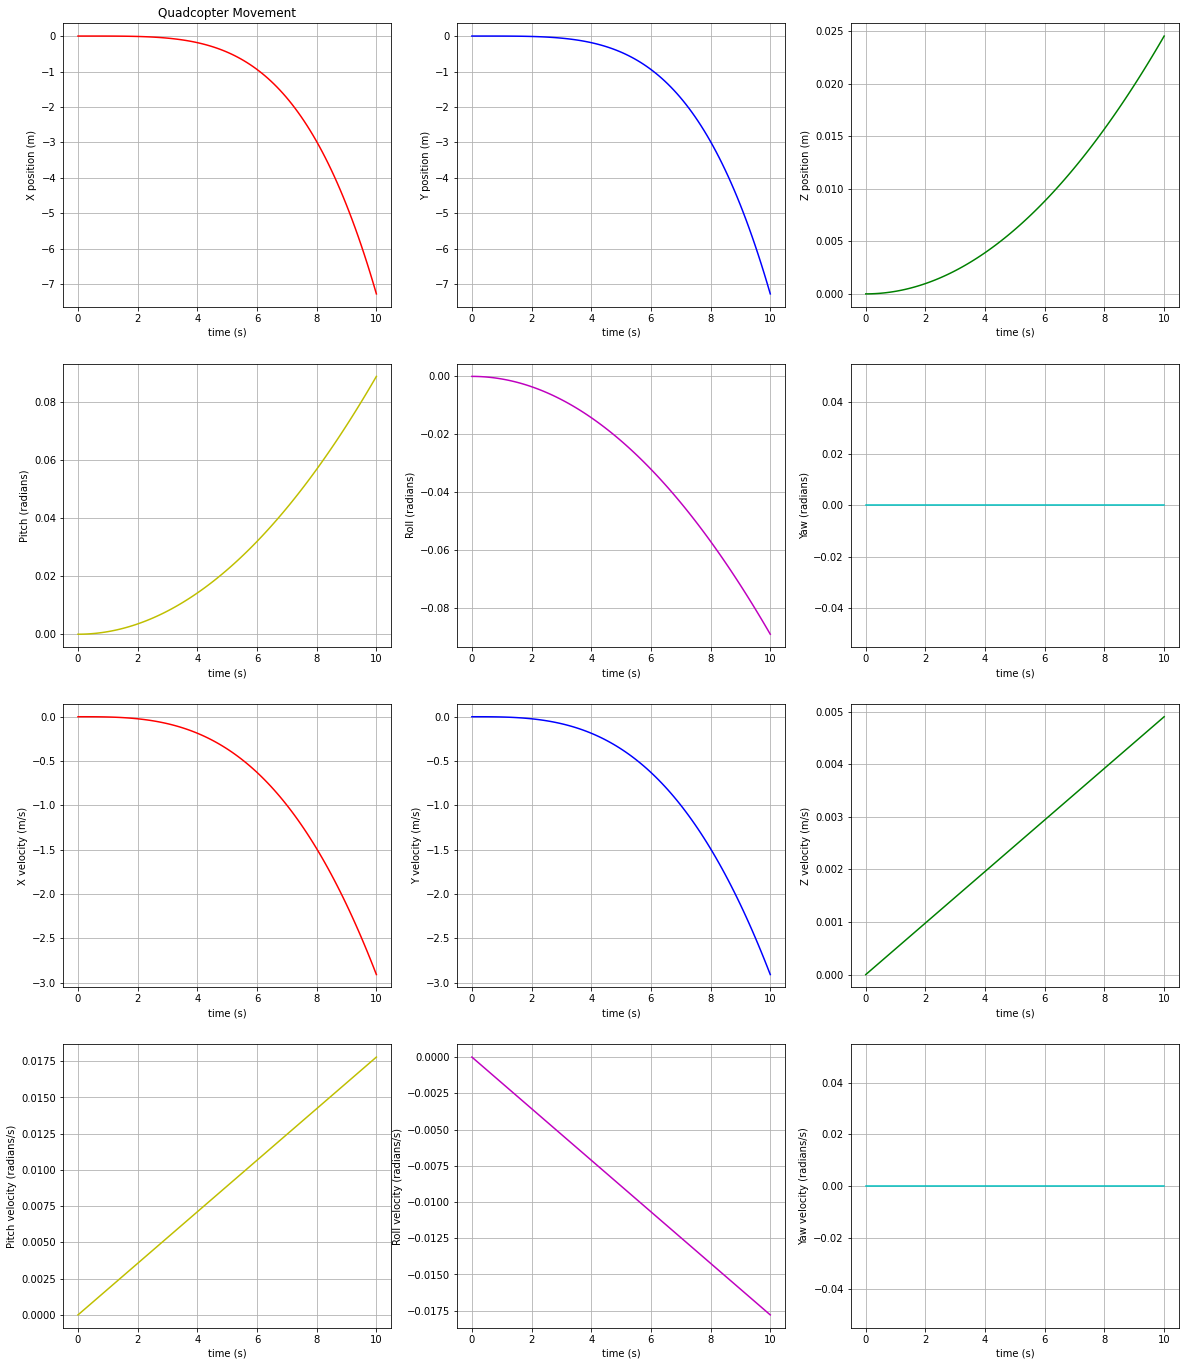

In [12]:
# apply forces such that the quadcopter will start translating and rotating
force = constants['m'] * constants['g'] / 4
delta_f = force * 0.0001
forces = [force] * 4

forces[0] += delta_f
forces[1] += delta_f

args = (forces, constants)
sol = solve_ivp(quadcopter, [0, 10], y0, args=args, dense_output=True)

t = np.linspace(0, 10, 100)
z = sol.sol(t)

# we expect the quadcopter start moving and rotating, but yaw should be 0
plot_all('Quadcopter Movement', t, z)

### PD Control
We can now redefine our function to include PD control.

Our trajectory generator will give us the desired x, y, z and yaw positions, velocities, and accelerations, allowing us to calculate the commanded values - which we derived earlier:

$\begin{bmatrix} \ddot{x_c} \\
\ddot{y_c} \\
\ddot{z_c}
\end{bmatrix} = \begin{bmatrix} \ddot{x_d} + K_{p,x}(x_d - x) + K_{d,x}(\dot{x_d} - \dot{x}) \\
\ddot{y_d} + K_{p,y}(y_d - y) + K_{d,y}(\dot{y_d} - \dot{y}) \\
\ddot{z_d} + K_{p,z}(z_d - z) + K_{d,z}(\dot{z_d} - \dot{z})
\end{bmatrix}$

and commanded rotation:

$\begin{bmatrix} \phi_c \\
\theta_c \\
\psi_c
\end{bmatrix} = \begin{bmatrix} \dfrac{\ddot{x_c}\sin{\psi_d} - \ddot{y_c}\cos{\psi_d}}{g} \\
\dfrac{\ddot{x_c}\cos{\psi_d} + \ddot{y_c}\sin{\psi_d}}{g} \\
\psi_d
\end{bmatrix}$

We can then calculate the following input $u$:

$\begin{bmatrix} u_1 \\
u_{2x} \\
u_{2y} \\
u_{2z}
\end{bmatrix} = \begin{bmatrix} m(g+\ddot{z_c}) \\
\ddot\phi_c + K_{p,\phi}(\phi_c - \phi) + K_{d,\phi}(\dot{\phi_c} - \dot{\phi}) \\
\ddot\theta_c + K_{p,\theta}(\theta_c - \theta) + K_{d,\theta}(\dot{\theta_c} - \dot{\theta}) \\
\ddot\psi_c + K_{p,\psi}(\psi_c - \psi) + K_{d,\psi}(\dot{\psi_c} - \dot{\psi})
\end{bmatrix}$

Once we have $u$ we can then solve for the individual rotor forces required.

#### Step Input and Hover
We will simplify the control loop such that we will give the quadcopter a step input - i.e. we will command the quadcopter to go to some point in 3D space with a particular yaw, with the assumption that the quadcopter should hover at this steady state. This is also ideal for tuning our PD controllers.

With a desired step input and hover steady state, we can zero out the commanded velocity and all further time derivatives:

$\begin{bmatrix} \ddot{x_c} \\
\ddot{y_c} \\
\ddot{z_c}
\end{bmatrix} = \begin{bmatrix} K_{p,x}(x_d - x) - K_{d,x}\dot{x} \\
K_{p,y}(y_d - y) - K_{d,y}\dot{y} \\
K_{p,z}(z_d - z) - K_{d,z}\dot{z} \end{bmatrix}$

$\begin{bmatrix} u_1 \\
u_{2x} \\
u_{2y} \\
u_{2z}
\end{bmatrix} = \begin{bmatrix} m(g+\ddot{z_c}) \\
K_{p,\phi}(\phi_c - \phi) - K_{d,\phi}\dot{\phi} \\
K_{p,\theta}(\theta_c-\theta) - K_{d,\theta}\dot{\theta} \\
K_{p,\psi}(\psi_c - \psi) - K_{d,\psi}\dot{\psi}
\end{bmatrix}$

In [13]:
# define our ivp function using our state space representation, and calculating the forces dynamically using PD control
# we will assume a simple trajectory planner that will send a desired hover position - so commanded velocites and accelerations will be 0
def quadcopter_pd(t, state, constants, desired, pd):
    # pull out desired values
    xd, yd, zd, psid = desired[0], desired[1], desired[2], desired[3]
    
    # pull out the pd tuples
    pdx, pdy, pdz, pdphi, pdtheta, pdpsi = pd[0], pd[1], pd[2], pd[3], pd[4], pd[5]
    
    # pull out the current state positions...
    x, y, z, phi, theta, psi = state[0], state[1], state[2], state[3], state[4], state[5]
    
    # ...and state velocities
    xv, yv, zv, phiv, thetav, psiv = state[6], state[7], state[8], state[9], state[10], state[11]
    
    # calculate commanded values
    xac = pdx[0]*(xd-x) - pdx[1]*xv
    yac = pdy[0]*(yd-y) - pdy[1]*yv
    zac = pdz[0]*(zd-z) - pdz[1]*zv
    phic = (xac*math.sin(psid) - yac*math.cos(psid)) / constants['g']
    thetac  = (xac*math.cos(psid) + yac*math.sin(psid)) / constants['g']
    psic = psid
    
    # calulate u
    u1 = constants['m'] * (constants['g'] + zac)
    u2x = pdphi[0]*(phic - phi) - pdphi[1]*phiv
    u2y = pdtheta[0]*(thetac - theta) - pdtheta[1]*thetav
    u2z = pdpsi[0]*(psic - psi) - pdpsi[1]*psiv
    
    # calculate updated accelerations
    u1_m = u1 / constants['m']
    x_accel = (math.cos(psi)*theta + math.sin(psi)*phi) * u1_m
    y_accel = (math.sin(psi)*theta - math.cos(psi)*phi) * u1_m
    z_accel = u1_m - constants['g']
    phi_accel = u2x / constants['Ixx']
    theta_accel = u2y / constants['Iyy']
    psi_accel = u2z / constants['Izz']
    
    updated = np.zeros(12)
    updated[0:6] = state[6:]
    updated[6:] = [x_accel, y_accel, z_accel, phi_accel, theta_accel, psi_accel]
    return updated

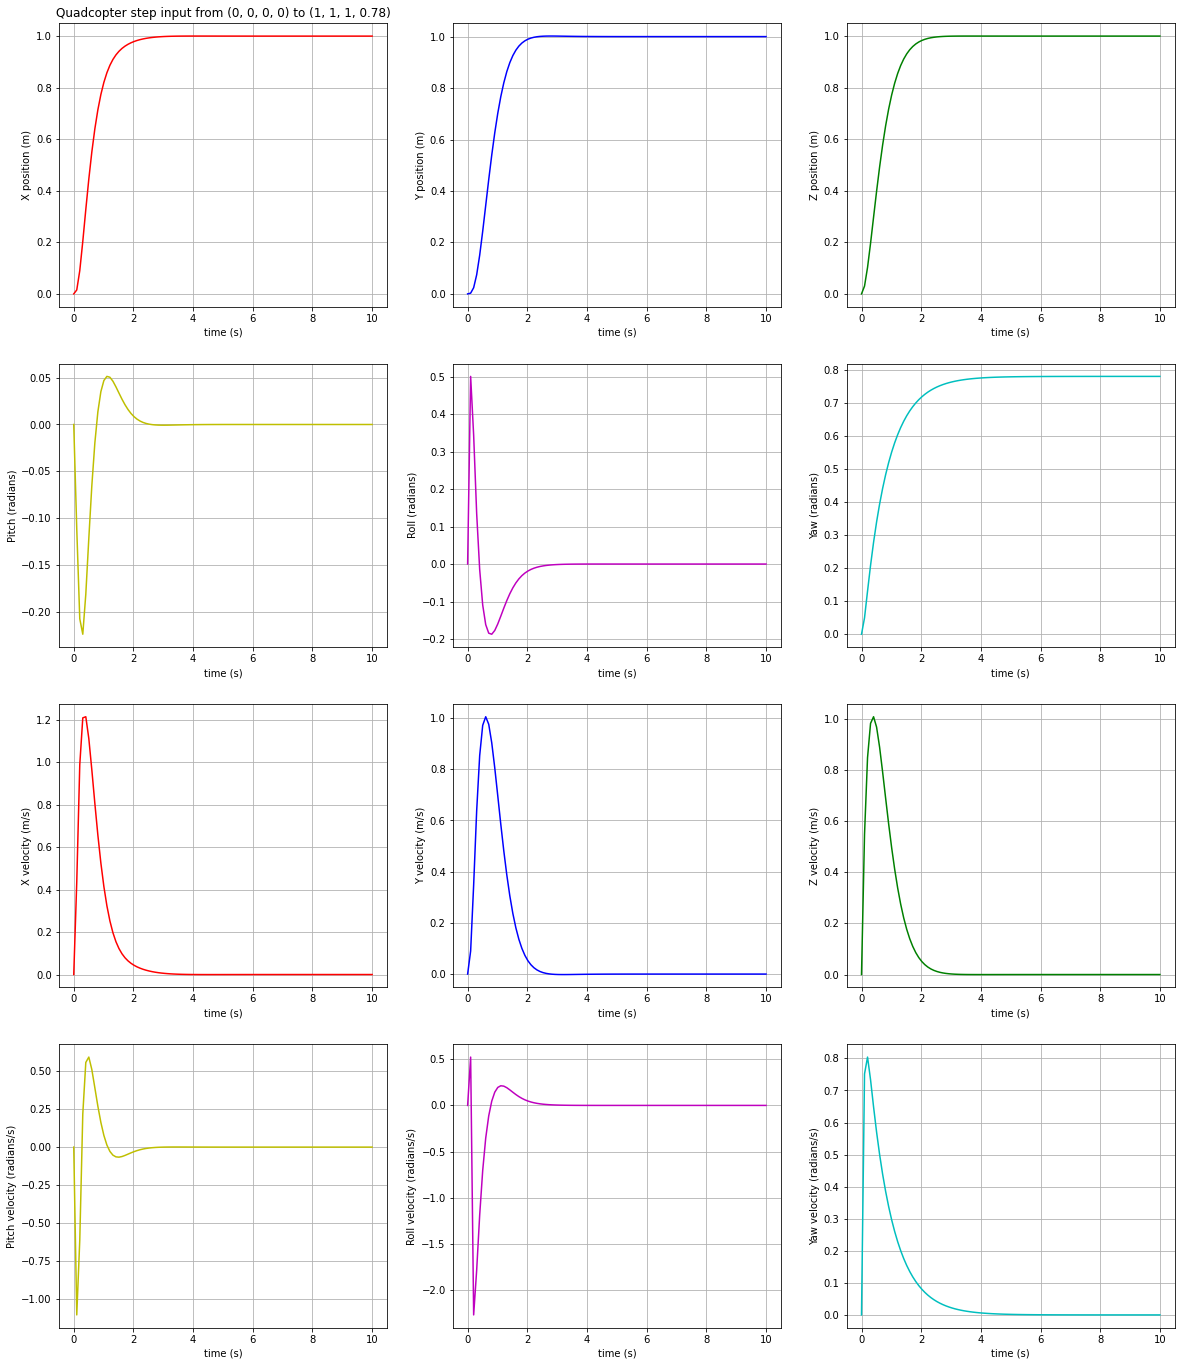

In [14]:
# x, y, z, yaw
desired = (1, 1, 1, 0.78)

# each tuple is a PD controller with the values as (P, D)
# we need PD controllers for x, y, z, pitch, roll and yaw
pd = [(3.5, 3.2), # x
      (4.7, 4), # y
      (7, 5), # z
      (10, 0.5), # phi
      (10, 0.5), # theta
      (0.3, 0.25)] # psi

args = (constants, desired, pd)
sol = solve_ivp(quadcopter_pd, [0, 10], y0, args=args, dense_output=True)

t = np.linspace(0, 10, 100)
z = sol.sol(t)

# we expect the quadcopter start moving and rotating, but yaw should be 0
plot_all(f'Quadcopter step input from (0, 0, 0, 0) to {desired}', t, z)

#### Putting into code

```python
# define our A matrix once and invert it to save processing time
A = np.array([[1, 1, 1, 1], 
              [0, constants['l'], 0, -constants['l']], 
              [-constants['l'], 0, constants['l'], 0],
              [constants['kmkf'], -constants['kmkf'], constants['kmkf'], -constants['kmkf']]])
Ainv = np.linalg.inv(A)

def control_loop(state):
    # 1. explode state into values
    # 2. get desired values from trajectory generator
    # 3. calculate commanded values using PID control values
    # 4. calculate u

    # solve for the rotor forces required
    u = np.array([[u1, u2x, u2y, u2z]]).transpose()
    f = Ainv*u
    
    # lastly, apply the forces to a simulation or convert into a voltage to apply to a motor
```